# Importing Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import arviz as az
import warnings
import textwrap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn import svm, tree, linear_model, neighbors
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,auc, roc_auc_score, roc_curve,classification_report, precision_recall_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
warnings.filterwarnings("ignore")

In [2]:
def set_sns_elements(pallete):
    sns.set_style("dark")
    sns.set_palette(pallete)
    sns.set_context("paper", font_scale=1)
    
set_sns_elements('plasma')
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

In [3]:
cust = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
cust.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
cust.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

# Discussion of notebook outline
1. Playing with data<br>
    a. Basic observations <br>
    b. Data Preprocessing<br>
    c. Visualise & Finding Patterns<br>
    d. Drawing some hypothesis<br>
    <br>
2. Modelling<br>
    a. Basic model training & feature reduction<br>
    b. Model Comparisons<br>
    c. Cross Validation<br>
    d. Hyperparamter Tuning for 2nd iteration of model evaluation<br><br>
3. Results & Business Analysis<br>
    a. Analyse the observations from step2<br>
    b. Relate the metrics from step 2 to business KPIs<br>
    c. Draw conclusions and possible improvement strategies for customer retention<br>
    

# Playing with data

In [6]:
cust.isna().sum().sum()

0

In [7]:
n_stat = cust.describe() #n_stat stands for numerical stats for numerical variables
n_stat

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## Data Cleaning

In [8]:
cust['TotalCharges'].replace(' ',np.NAN,inplace=True)
cust['TotalCharges'] = cust['TotalCharges'].astype(float)

In [9]:
cust.isna().sum().sum() #Previously we had 0 missing values but now we have 11 missing

11

In [10]:
tc = SimpleImputer(strategy='mean').fit_transform(cust['TotalCharges'].values.reshape(-1,1))
cust['TotalCharges']=tc


In [11]:
n_stat = cust.describe() #n_stat stands for numerical stats for numerical variables
n_stat

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2265.000258
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1400.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [12]:
col = list(cust.columns)
c_col = [i for i in col if i not in n_stat.columns] #c_col stands for categorical columns

In [13]:
c_col.append('SeniorCitizen') 
c_col.remove('customerID') 

In [14]:
c_multi = {} #For categorical features, dictionary with feature and respective unique classes
for i in c_col:
    c_multi[i]=cust[i].unique()

In [15]:
c_multi

{'gender': array(['Female', 'Male'], dtype=object),
 'Partner': array(['Yes', 'No'], dtype=object),
 'Dependents': array(['No', 'Yes'], dtype=object),
 'PhoneService': array(['No', 'Yes'], dtype=object),
 'MultipleLines': array(['No phone service', 'No', 'Yes'], dtype=object),
 'InternetService': array(['DSL', 'Fiber optic', 'No'], dtype=object),
 'OnlineSecurity': array(['No', 'Yes', 'No internet service'], dtype=object),
 'OnlineBackup': array(['Yes', 'No', 'No internet service'], dtype=object),
 'DeviceProtection': array(['No', 'Yes', 'No internet service'], dtype=object),
 'TechSupport': array(['No', 'Yes', 'No internet service'], dtype=object),
 'StreamingTV': array(['No', 'Yes', 'No internet service'], dtype=object),
 'StreamingMovies': array(['No', 'Yes', 'No internet service'], dtype=object),
 'Contract': array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 'PaperlessBilling': array(['Yes', 'No'], dtype=object),
 'PaymentMethod': array(['Electronic check', 'Mailed 

In [16]:
cust['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [17]:
5174/(5174+1869)

0.7346301292063041

## Basic Observations
1. No missing values : Great positive indicator of good quality data, no need of SimpleImputer or any other missing data treatment <br>
2. Hereby we can observer that TotalCharges is not being considered as Numerical data contrary to what should actually happen. <br>
It is mis-given as strings hence considered inherently as categorical. <br>
3. No redundancy of categories due to spelling mistakes or case sensitivity : Indicator of good quality data <br>
4. Imbalanced dataset <br>
5. We can see that the average customer retention rate is 0.73 <br>

## Standard EDA

### Numerical Features

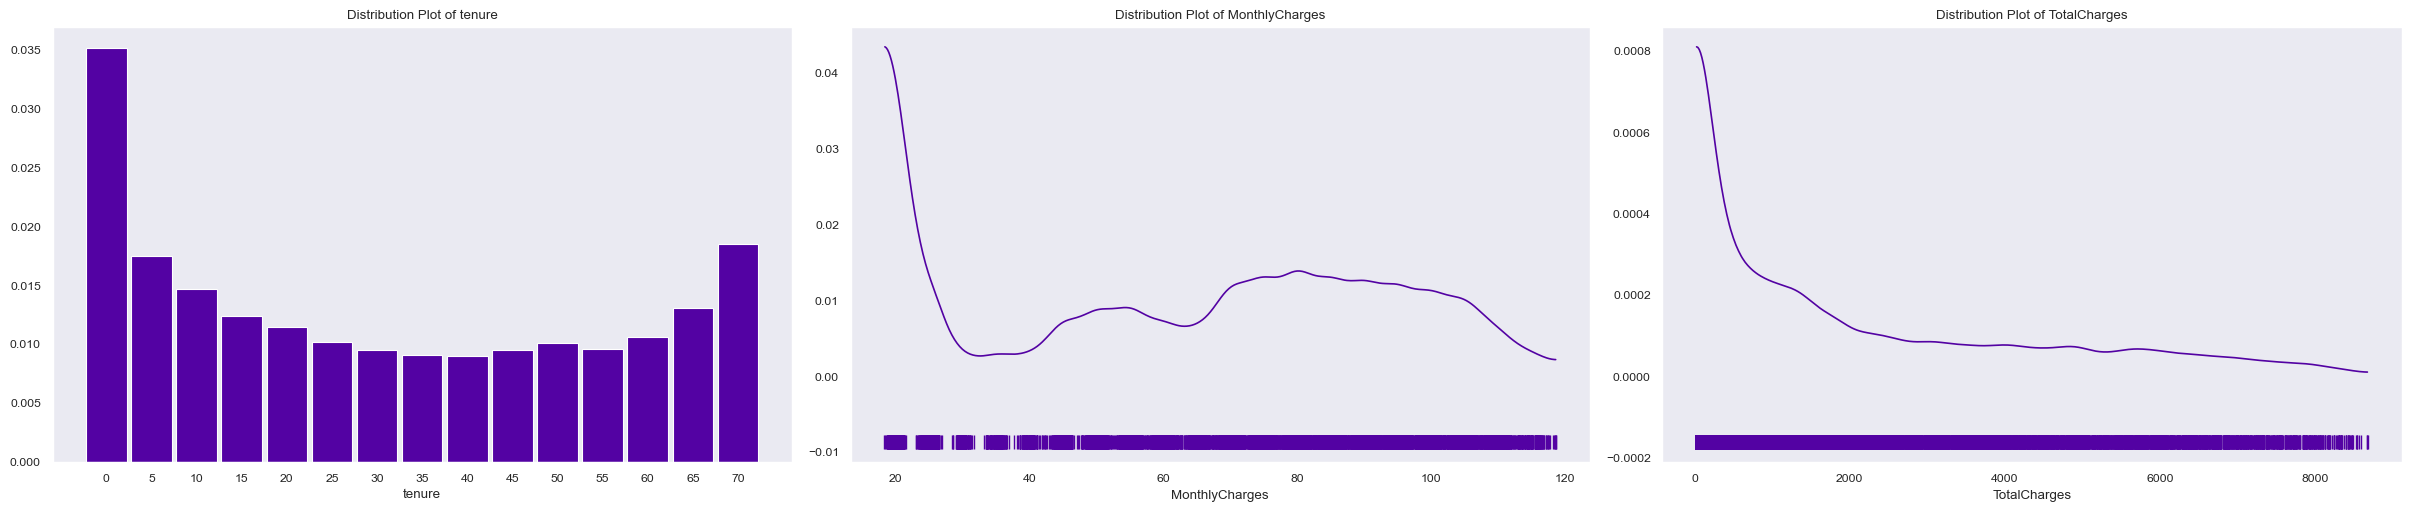

In [18]:
n_col=['tenure','MonthlyCharges','TotalCharges']
def plot_dist_plot(cols,nrow=1,ncol=None):
    # single_item_dimensions = (8, 5)
    if ncol is None:
        ncol = len(cols)
    fig, axes = plt.subplots(nrow, ncol, constrained_layout=True, figsize=(24,5))
    for i in range(nrow):
        for j in range(ncol):
            az.plot_dist(cust[cols[j]].values, ax=axes[j],rug=True)
            axes[j].set_xlabel(cols[j])
            axes[j].set_title(f"Distribution Plot of {cols[j]}")
plot_dist_plot(n_col)

### Categorical Features

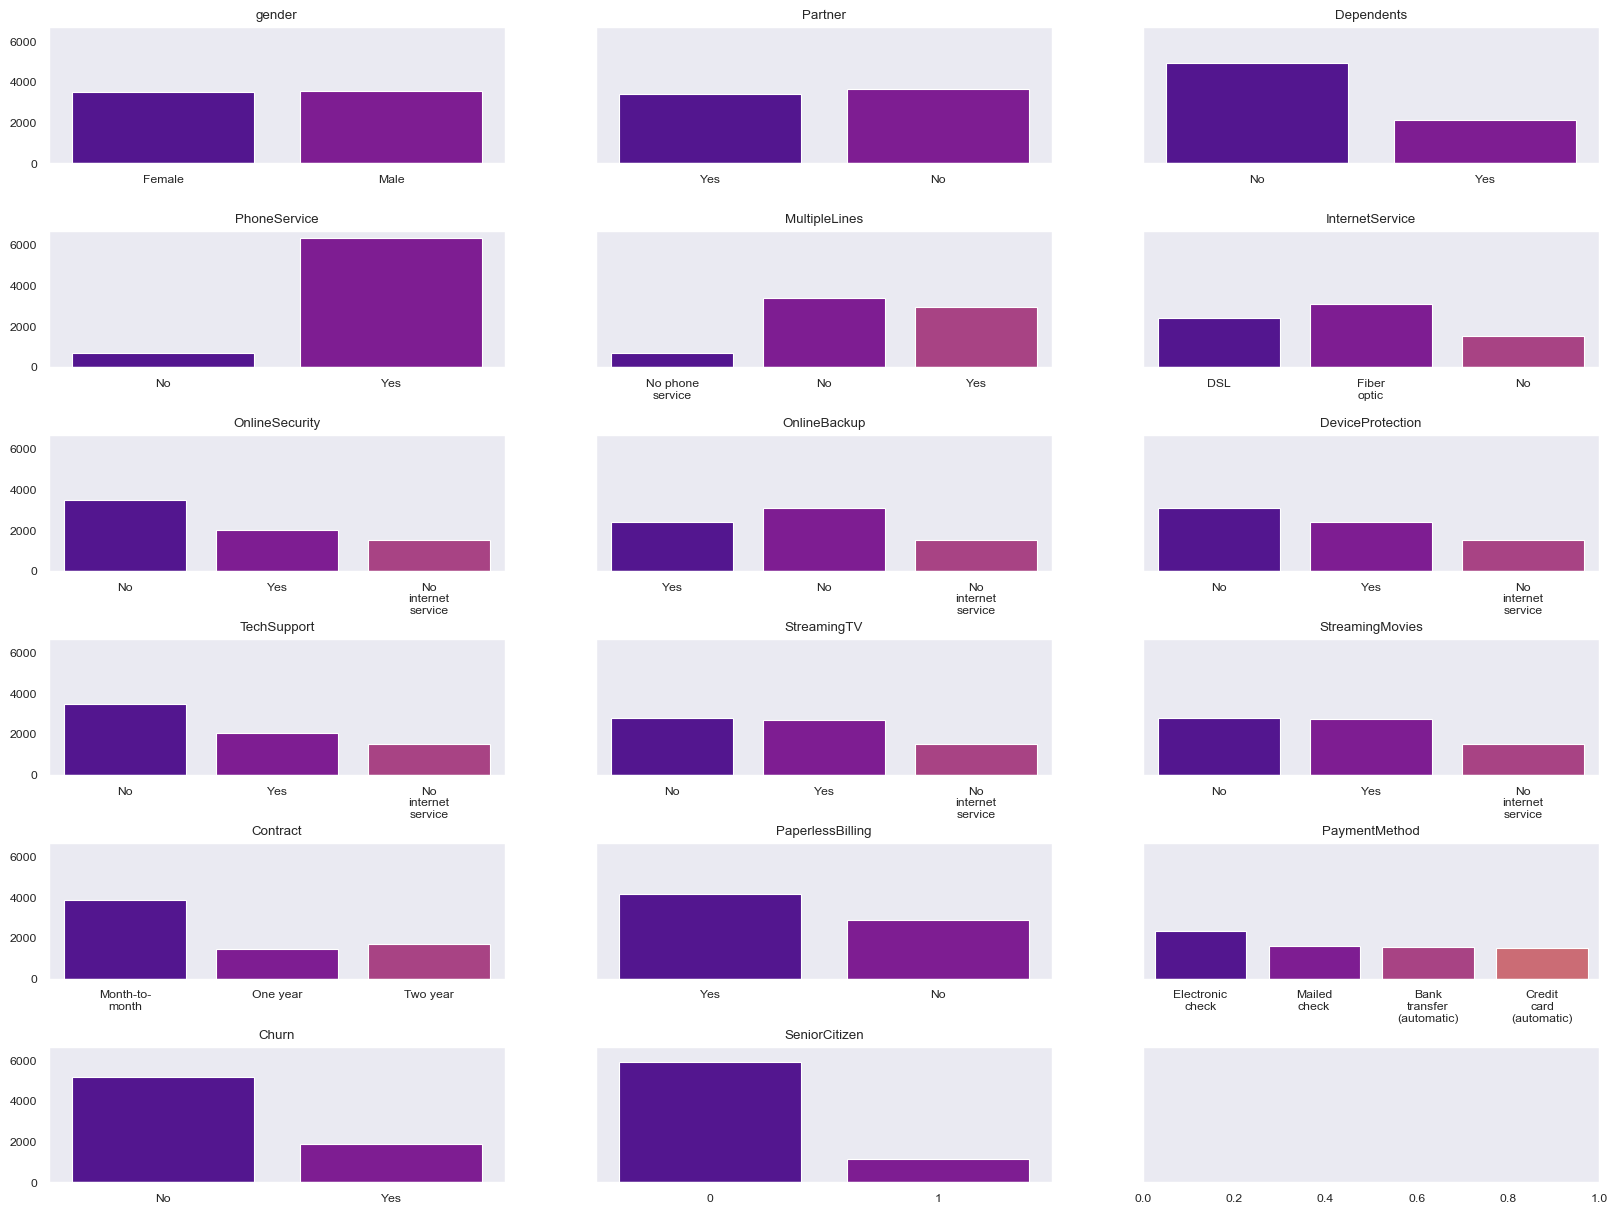

In [19]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(20, 15),sharey=True)
plt.subplots_adjust(hspace=0.5)
# c_col.remove('customerID')
for ticker, ax in zip(c_col, axs.ravel()):
    cust[cust[ticker] == ticker].plot(ax=ax)
    sns.countplot(cust[ticker],ax=ax)  
    wrap_labels(ax,10)
    ax.get_legend().remove()
    ax.set_title(ticker)
    ax.set_ylabel("")
    ax.set_xlabel("")
    

plt.show()

### LabelEncoding

In [20]:
cust_copy =cust.copy()
le = LabelEncoder()
for i in c_multi.keys():
    if(c_multi[i].shape[0]==2):
        cust[i]= le.fit_transform(cust[i])


### Correlation

<AxesSubplot:>

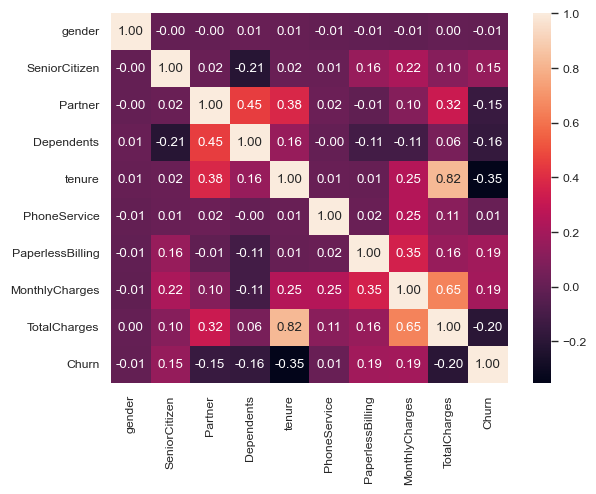

In [21]:
sns.heatmap(cust.corr(),annot=True, fmt=".2f")

### Correlation with Churn

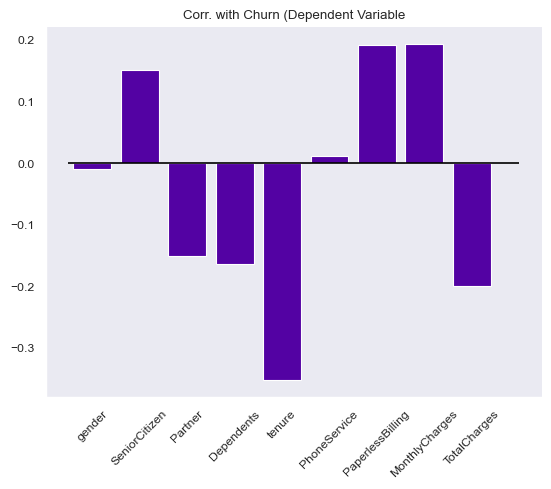

In [22]:
cust_corr= cust.drop(columns='Churn').corrwith(cust.Churn)
plt.bar(cust_corr.index,cust_corr)
plt.hlines(0,xmin=-0.5,xmax=9,color='black')
plt.xticks(rotation=45)
plt.title('Corr. with Churn (Dependent Variable')
sns.despine()

In [23]:
cust = pd.get_dummies(cust.drop(columns='customerID'))

In [24]:
cust

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,84.80,1990.50,0,...,0,0,1,0,1,0,0,0,0,1
7039,0,0,1,1,72,1,1,103.20,7362.90,0,...,0,0,1,0,1,0,0,1,0,0
7040,0,0,1,1,11,0,1,29.60,346.45,0,...,1,0,0,1,0,0,0,0,1,0
7041,1,1,1,0,4,1,1,74.40,306.60,1,...,1,0,0,1,0,0,0,0,0,1


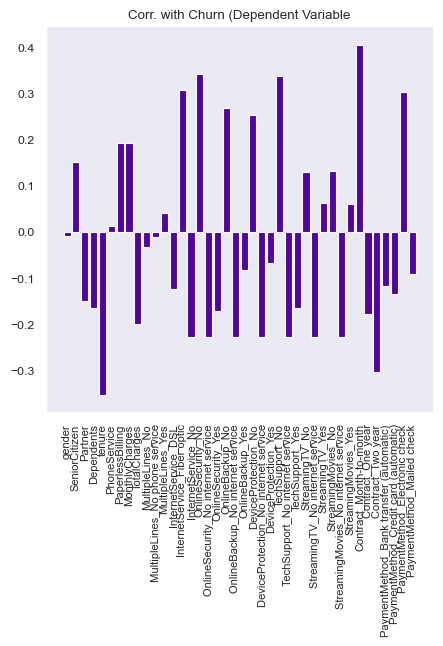

In [25]:
cust_corr= cust.drop(columns='Churn').corrwith(cust.Churn)
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.bar(cust_corr.index,cust_corr)
plt.xticks(rotation=90,fontsize=8)
plt.title('Corr. with Churn (Dependent Variable')
# wrap_labels(ax)
sns.despine()

In [26]:
cust_corr

gender                                    -0.008612
SeniorCitizen                              0.150889
Partner                                   -0.150448
Dependents                                -0.164221
tenure                                    -0.352229
PhoneService                               0.011942
PaperlessBilling                           0.191825
MonthlyCharges                             0.193356
TotalCharges                              -0.199428
MultipleLines_No                          -0.032569
MultipleLines_No phone service            -0.011942
MultipleLines_Yes                          0.040102
InternetService_DSL                       -0.124214
InternetService_Fiber optic                0.308020
InternetService_No                        -0.227890
OnlineSecurity_No                          0.342637
OnlineSecurity_No internet service        -0.227890
OnlineSecurity_Yes                        -0.171226
OnlineBackup_No                            0.268005
OnlineBackup

In [27]:
### Let's talk about multicollinearity
def vif_func(df):
    vif = pd.DataFrame()
    vif["feat"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) 
    for i in range(df.shape[1])]
    return vif
vif = vif_func(cust.drop(columns='Churn')).sort_values(by='VIF')[:8]
vif



,feat,VIF
0,gender,1.002151
1,SeniorCitizen,1.153352
6,PaperlessBilling,1.209019
3,Dependents,1.384160
2,Partner,1.462800
4,tenure,7.304521
8,TotalCharges,10.541130
7,MonthlyCharges,865.053343


In [28]:
#Total Charges and Monthly Charges are having high VIF and from external pov also the features look redundant 
#By rule of thumb also they have vif above 10.
#Hence we can remove monthly charges!

In [29]:
cust.drop(columns='MonthlyCharges',inplace=True)

In [30]:
vif_func(cust).sort_values(by='VIF')[:8]

,feat,VIF
0,gender,1.002058
1,SeniorCitizen,1.155238
6,PaperlessBilling,1.212415
3,Dependents,1.384748
8,Churn,1.397345
2,Partner,1.462397
4,tenure,7.308087
7,TotalCharges,10.586296


In [31]:
cust

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,TotalCharges,Churn,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,0,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1889.50,0,1,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,108.15,1,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1840.75,0,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,151.65,1,1,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,1990.50,0,0,...,0,0,1,0,1,0,0,0,0,1
7039,0,0,1,1,72,1,1,7362.90,0,0,...,0,0,1,0,1,0,0,1,0,0
7040,0,0,1,1,11,0,1,346.45,0,0,...,1,0,0,1,0,0,0,0,1,0
7041,1,1,1,0,4,1,1,306.60,1,0,...,1,0,0,1,0,0,0,0,0,1


In [32]:
# Now the data is prepared for model pipeline
# Now we do train test split and scale the data

## Data Preprocessing

### Scale the data 

In [33]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaled_features = pd.DataFrame(StandardScaler().fit_transform(cust.loc[:,['tenure','TotalCharges']].values))
cust['tenure']=scaled_features[0]
cust['TotalCharges']=scaled_features[1]

In [34]:
cust

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,TotalCharges,Churn,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,-1.277445,0,1,-0.994971,0,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,0.066327,1,0,-0.173876,0,1,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,-1.236724,1,1,-0.960399,1,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,0.514251,0,0,-0.195400,0,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,-1.236724,1,1,-0.941193,1,1,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,-0.340876,1,1,-0.129281,0,0,...,0,0,1,0,1,0,0,0,0,1
7039,0,0,1,1,1.613701,1,1,2.242808,0,0,...,0,0,1,0,1,0,0,1,0,0
7040,0,0,1,1,-0.870241,0,1,-0.855182,0,0,...,1,0,0,1,0,0,0,0,1,0
7041,1,1,1,0,-1.155283,1,1,-0.872777,1,0,...,1,0,0,1,0,0,0,0,0,1


In [35]:
X,y=cust.drop(columns='Churn'),cust['Churn']

### Train Test Split using Stratified Sampling

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [37]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((5282, 39), (5282,), (1761, 39), (1761,))

# Predictive Modelling

### Algorithm Comparison <br> 5 Fold Cross Validation

In [38]:
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Linear SVM', SVC(kernel = 'linear', )))
models.append(('Kernel SVM', SVC(kernel = 'rbf', )))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree Classifier',DecisionTreeClassifier(criterion = 'entropy', random_state = 0)))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('XGBoost',XGBClassifier()))
acc_results = []
auc_results = []
f1_results = []
names = []
col = ['Algorithm', 'ROC AUC', 'ROC AUC Std','Accuracy', 'Accuracy Std','f1 Weighted','f1 std']
model_results = pd.DataFrame(columns=col)
i = 0

for name, model in models:
    kfold = model_selection.KFold(shuffle=True, n_splits=5, random_state=42)
    cv_acc_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='balanced_accuracy')
    cv_auc_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    cv_f1_results = model_selection.cross_val_score(model,X_train,y_train,cv=kfold,scoring='f1_weighted')
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    f1_results.append(cv_f1_results)
    names.append(name)
    model_results.loc[i] = [name,
                        round(cv_auc_results.mean()*100, 3),
                        round(cv_auc_results.std()*100, 3),
                        round(cv_acc_results.mean()*100, 3),
                        round(cv_acc_results.std()*100, 3),
                        round(cv_f1_results.mean()*100, 3),
                        round(cv_f1_results.std()*100, 3)
                        ]
    i += 1
    


In [39]:
model_results.sort_values(by=['ROC AUC','f1 Weighted'], ascending=False)

,Algorithm,ROC AUC,ROC AUC Std,Accuracy,Accuracy Std,f1 Weighted,f1 std
0,Logistic Regression,85.030,0.746,72.887,1.299,80.239,1.568
1,Linear SVM,83.973,0.880,72.606,1.830,79.884,1.744
6,XGBoost,82.570,0.609,70.439,1.381,78.196,1.302
5,Random Forest,82.442,1.013,69.641,1.074,78.282,1.158
2,Kernel SVM,80.509,0.751,71.388,1.440,79.568,1.718
3,KNN,79.628,1.132,70.711,1.496,77.776,1.753
4,Decision Tree Classifier,65.551,1.348,65.344,1.320,73.067,1.283


### Iteration 2

#### Hyperparameter Tuning with Cross Validation

In [40]:
lR = LogisticRegression() 
lR.fit(X_train,y_train) 

LogisticRegression()

In [45]:
lR_b_f1_cv = model_selection.cross_val_score(lR, X_train, y_train, cv=kfold, scoring='f1_weighted')
lR_b_f1_cv.mean(),lR_b_f1_cv.std()

(0.8023881942743166, 0.01568308221937352)

In [42]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_b_f1_cv = model_selection.cross_val_score(rf, X_train, y_train, cv=kfold, scoring='f1_weighted')
rf_b_f1_cv.mean(),rf_b_f1_cv.std()


(0.7808021518360533, 0.014342578848033328)

In [51]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 100)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4,8]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random= RandomizedSearchCV(rf,random_grid)
rf_random.fit(X_train,y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 206, 212, 218,
                                                         224, 230, 236, 242,
                                                         248, 254, 260, 266,
                                                         272, 278, 284, 290,
                                                         296, 303, 309, 315,
                                                         321, 327, 333, 339,
                                                         345, 351, 357, 363,
                                                         369, 375, ...]})

In [44]:
rf_f1_cv = model_selection.cross_val_score(rf_random, X_train, y_train, cv=kfold, scoring='f1_weighted')
rf_f1_cv.mean(),rf_f1_cv.std()

(0.7922270241497881, 0.010262196764185024)

In [46]:
print("Improvement in cross validated f1 score",rf_f1_cv.mean() - rf_b_f1_cv.mean())

Improvement in cross validated f1 score 0.01142487231373479


#### Feature Selection

In [52]:
fi=pd.DataFrame()
fi['features']=cust.drop(columns='Churn').columns
fi['imp_lr']=lR.coef_[0]
fi['imp_rf']=rf_random.best_estimator_.feature_importances_
scaled_fi = pd.DataFrame(MinMaxScaler().fit_transform(fi.iloc[:,1:].values))
fi['imp_lr']=scaled_fi[0]
fi['imp_rf']=scaled_fi[1]
fi['sum']=fi['imp_lr']+fi['imp_rf']

## Iteration 3 : Final Model Building

Use Top 6 features from random forest and use in Logistic Regression

In [73]:
imp_features= fi.sort_values(by='imp_rf',ascending=False).head(6)['features'].values
data_new = cust.loc[:,imp_features]
X=data_new.values
y=cust['Churn'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [84]:

lR_new = LogisticRegression(penalty='l2')
lR_new.fit(X_train,y_train)

LogisticRegression()

In [85]:
print(round(f1_score(y_test,lR_new.predict(X_test),average='weighted'),4),round(accuracy_score(y_test,lR_new.predict(X_test),),4))


0.7897 0.7922


Text(0.5, 1.0, 'Confusion Matrix')

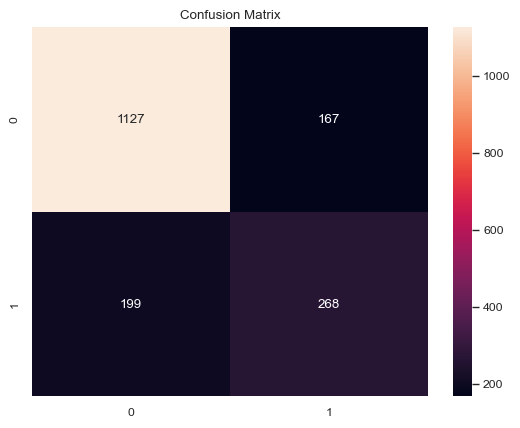

In [98]:
sns.heatmap(confusion_matrix(y_test,lR_new.predict(X_test)),annot=True,fmt='g')
plt.title('Confusion Matrix')

Text(0.5, 1.0, 'AUC : Logistic Regression (area = 0.79)')

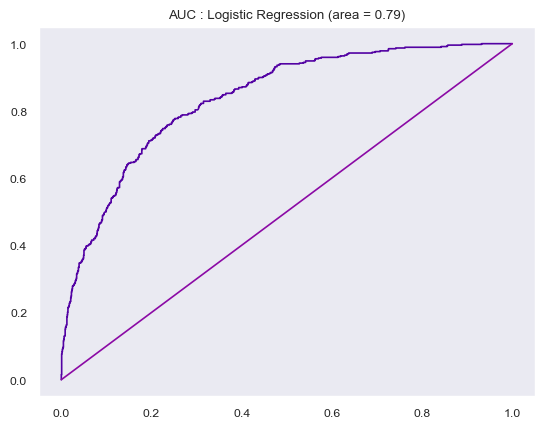

In [99]:
classifier_roc_auc = accuracy_score(y_test, lR_new.predict(X_test) )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, lR_new.predict_proba(X_test)[:,1])
plt.plot(rf_fpr, rf_tpr)
plt.plot([0,1],[0,1])
plt.title('AUC : Logistic Regression (area = %0.2f)'%classifier_roc_auc )

In [100]:
imp_features

array(['tenure', 'Contract_Month-to-month', 'TotalCharges',
       'OnlineSecurity_No', 'InternetService_Fiber optic',
       'TechSupport_No'], dtype=object)

## Result : with approximately same f1 score  we reduced features from 39 to 6 hence saving loads of computation power. Also accuracy improved from 73 to 79.2